In [4]:
##Initialization
%matplotlib inline

import EMpy
import numpy as np
import matplotlib.pyplot as plt


##Define constants that will be used later
hc = 1239.84193 ##ev*nm
c = 299792458.
mu0 = 4. * np.pi * 1e-7
ep0 = 1. / (c**2 * mu0)

## User Inputs 

#### E           - Photon energy (currently working with a single energy scan)

#### theta_start - The start angle for the rocking scan

#### theta_end   - The end angle for the rocking scan

#### numpnts     - The number of points in your theta scan

Q-vector will be calculated from these settings 

In [5]:
##User Input##
#Energy
E = 250. ##eV
#Start angle
theta_start = 1.2 #deg
#End angle
theta_end = 80 #deg
#number of points to simulate
numpnts = 1000


##Initialize user inputs
wl = hc/E * 10 #calc wavelength in A
theta_scan = np.linspace(theta_start,theta_end,numpnts)*np.pi/180
qvals = (4*np.pi/wl) * np.sin(theta_scan)



wls = np.array([wl*1e-10]) ##convert wl to m for later calculations
theta_exp = np.pi/2 - theta_scan ##Inverted for TMM calculation w/ 0deg --> normal to surface
theta_deg = np.linspace(theta_start,theta_end,numpnts) #for reality checks

## Optical tensor definitions

Create optical tensors for each slab as 3x3 numpy arrays 

In [6]:
#define the optical tensor for each layer
##Silicon
##SiO2
##TCT
#Air
#From Jacob optical parameters #250eV
Silicon_epsilon = (0.98805666 + 1j*0.008500482)  * np.eye(3) * ep0
SiO2_epsilon = (0.988016631 + 1j*0.00463295) * np.eye(3) * ep0
TCT_epsilon = (0.994973599 + 1j*0.000284496) * np.eye(3) * ep0
TCT_epsilon_1pt1 = (0.995663497 + 1j*0.000245447) * np.eye(3) * ep0

#From Jacob optical parameters #284.7eV
Silicon_epsilon_res = (0.990206998 + 1j*0.005603499)  * np.eye(3) * ep0

exx = 1.00086 + 1j*0.0002
ezz = 1.00098 + 1j*0.00038
TCT_epsilon_res = np.diag([exx,exx,ezz])*ep0

exx_s = 1.00038 + 1j*0.00304
ezz_s = 0.99996 + 1j*0
Surface_res = np.diag([exx_s,exx_s,ezz_s])*ep0
Air_epsilon = np.eye(3)*ep0

##From EMpy example tensor
layer1 = 1**2* np.eye(3)* ep0
layer2 = np.diag([2.1, 2.0, 1.9])* ep0
layer3 = 2.3 ** 2 * np.eye(3)* ep0
layer4 = 4.3 ** 2 *  np.eye(3)* ep0
layer5 = 3.0 ** 2 * np.eye(3)* ep0

##Testing comparison w/ ReMagX fake tensors
Silicon_Tensor = (0.988+ 1j*0.009) * np.eye(3) * ep0 # 

#epsilon_1_xx = (1.008 + 1j*0.008)
##epsilon_1_zz = (1.014 + 1j*0.004) 
#epsilon_2_xx = (1.004 + 1j*0.002) 
#epsilon_2_zz = (1.010 + 1j*0.002)

epsilon_1_xx = (1.00086 + 1j*0.0002)
epsilon_1_zz = (1.00098 + 1j*0.00038) 
epsilon_2_xx = (1.0038 + 1j*0.00304) 
epsilon_2_zz = (0.9996 + 1j*0)

epsilon_1 = np.diag([epsilon_1_xx,epsilon_1_xx,epsilon_1_zz]) * ep0
epsilon_2 = np.diag([epsilon_2_xx,epsilon_2_xx,epsilon_2_zz]) * ep0


### Create slab model from optical tensors

#### [Surface , Top Layer , ... , Bottom layer, Substrate]

In [7]:
##Consolidate the structure of the film as a multilayer

#epsilon = [Silicon_epsilon,SiO2_epsilon,Air_epsilon]
#epsilon = [Air_epsilon,TCT_epsilon_1pt1,Silicon_epsilon]
#epsilon = [Air_epsilon,Surface_res,TCT_epsilon_res,Silicon_epsilon_res]
#epsilon = [Silicon_epsilon,SiO2_epsilon,Air_epsilon]

#epsilon = [Air_epsilon, Silicon_epsilon]
#epsilon = [Silicon_epsilon,Air_epsilon]

#epsilon = [layer1,layer2,layer3,layer4,layer5]
epsilon = [Air_epsilon, epsilon_2, epsilon_1, Silicon_Tensor]

### Assign thickness to each slab

Order follows the slab model defined above. All units in meters

End layers don't seem to matter, I keep them as 'np.inf'

In [8]:
#Define the thicknes of each layer ##must match the size of the multilayer
#d = np.array([np.inf,500e-10,np.inf])
#d = np.array([np.inf, 15e-10,710e-10, np.inf])
#d = np.array([np.inf, 1e-7, 2.3e-7, 0.1e-7, np.inf])
#d = np.array([np.inf,5e-6,np.inf])
#d = np.array([np.inf,np.inf])

d = np.array([np.inf, 50e-10,200e-10, np.inf])

#### Convert into EMpy layer structure

In [9]:
##Generate the multilayer Object for EMPy
aniso_layers = EMpy.utils.Multilayer()
for i in range(len(epsilon)):
    eps = EMpy.materials.EpsilonTensor(epsilon[i] * np.eye(3))
    mat = EMpy.materials.AnisotropicMaterial('layer_%d' % i, eps)
    layer = EMpy.utils.Layer(mat, d[i])
    aniso_layers.append(layer)


#### Calculate the reflectivity

In [11]:
#Calculate the reflectivity

#Make empty arrays to store reflectivity data (Currently working for a single energy)
Reflect_SS = np.zeros(numpnts) ##reflectivity of Spol
Reflect_PP = np.zeros(numpnts) ##reflectivty of Ppol
Reflect_SP = np.zeros(numpnts) ##reflectivity of Spol to Ppol
Reflect_PS = np.zeros(numpnts) ##reflectivity of Ppol to Spol



for i,theta in enumerate(theta_exp):
    tm = EMpy.transfer_matrix.AnisotropicTransferMatrix(aniso_layers,theta,0) # first zero needs ot be theta
    solution_aniso = tm.solve(wls)
   # print(solution_aniso.R)
    Reflect_SS[i] = solution_aniso.R[0,0,0]
    Reflect_SP[i] = solution_aniso.R[0,1,0]
    Reflect_PP[i] = solution_aniso.R[1,1,0]
    Reflect_PS[i] = solution_aniso.R[1,0,0]

#### A simple plot

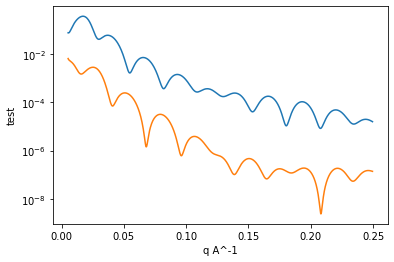

In [14]:
#plot results
plt.plot()
plt.yscale('log')
plt.plot(qvals,Reflect_SS,qvals,Reflect_PP*0.01)
plt.ylabel('test')
plt.xlabel('q A^-1')
plt.show()

In [27]:
##Save results
saveQ = qvals.reshape(numpnts,1)
saveRS = Reflect_SS.reshape(numpnts,1)
saveRP = Reflect_PP.reshape(numpnts,1)
np.savetxt('qVals.csv',(saveQ),delimiter=',')
np.savetxt('ReflectS.csv',(saveRS),delimiter=',')
np.savetxt('ReflectP.csv',(saveRP),delimiter=',')